# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url)
btc_content = btc_data.content
btc_info = btc_data.json()

# print(json.dumps(btc_info, indent=4))

btc_price = btc_info['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_data = requests.get(eth_url)
eth_content = eth_data.content
eth_info = eth_data.json()

# print(json.dumps(eth_info, indent=4))

eth_price = eth_info['data']['1027']['quotes']['USD']['price']


# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $49220.40
The current value of your 5.3 ETH is $14657.57


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
# Format current date as ISO format

start_date = pd.Timestamp("2022-03-14", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-03-14", tz="America/New_York").isoformat()


# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
ticker_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Preview DataFrame
ticker_data.head()

C:\Users\Avi\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:20: DeprecatedWarning: get_barset is deprecated as of v1.0.0. Use get_bars instead


AGG                                       SPY  \
                             open     high     low   close   volume    open   
time                                                                          
2022-03-14 00:00:00-04:00  107.78  107.816  107.36  107.38  9445533  420.89   

                                                             
                             high     low   close    volume  
time                                                         
2022-03-14 00:00:00-04:00  424.55  415.79  417.03  84023951

In [16]:
df_closing_prices = pd.DataFrame()

for ticker in tickers:
    df_closing_prices[ticker] = ticker_data[ticker]["close"]

    
df_closing_prices.index = df_closing_prices.index.date    
df_closing_prices.head()



,AGG,SPY
2022-03-14,107.38,417.03


In [20]:
# Pick AGG and SPY close prices

# agg_close_price = ticker_data.iloc[0][3]
# spy_close_price = ticker_data.iloc[0][8]

agg_close_price = df_closing_prices['AGG'].values
spy_close_price = df_closing_prices['SPY'].values


# # Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $[107.38]
Current SPY closing price: $[417.03]


In [21]:
# Compute the current value of shares
my_agg_value = float(my_agg * agg_close_price)
my_spy_value = float(my_spy * spy_close_price)

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value}")

The current value of your 50 SPY shares is $20851.5
The current value of your 200 AGG shares is $21476.0


### Savings Health Analysis

In [22]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_value = my_btc_value + my_eth_value
shares_value = my_agg_value + my_spy_value


# # Create savings DataFrame
type_of_investment = ['crypto', 'shares']
investment_values = {'amounts': [crypto_value, shares_value]}

df_savings = pd.DataFrame(investment_values, index=type_of_investment)

# # Display savings DataFrame
display(df_savings)

,amounts
crypto,63877.974
shares,42327.500


<AxesSubplot:title={'center':'Value of Securities Composition'}, ylabel='amounts'>

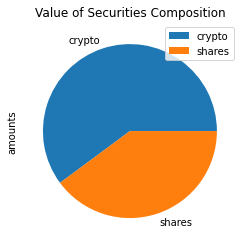

In [23]:
# Plot savings pie chart

df_savings.plot.pie( y="amounts", title="Value of Securities Composition")

In [39]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amounts'][0] + df_savings['amounts'][1]

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations for having enough money in this fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching this financial goal.")
else:
    dollar_goal = emergency_fund - total_savings
    print(dollar_goal)
        

Congratulations for having enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)

df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit=1000).df

# Display sample data
df_stock_data.head()

C:\Users\Avi\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:9: DeprecatedWarning: get_barset is deprecated as of v1.0.0. Use get_bars instead
  if __name__ == '__main__':


AGG                                         \
                             open     high       low    close     volume   
time                                                                       
2017-05-10 00:00:00-04:00  108.60  108.660  108.4400  108.520  1427511.0   
2017-05-11 00:00:00-04:00  108.35  108.540  108.3435  108.515  1773499.0   
2017-05-12 00:00:00-04:00  108.81  108.940  108.7800  108.920  1136553.0   
2017-05-15 00:00:00-04:00  108.85  108.940  108.8200  108.890  1620264.0   
2017-05-16 00:00:00-04:00  108.88  109.101  108.8800  109.000  1394153.0   

                              SPY                                       
                             open    high     low    close      volume  
time                                                                    
2017-05-10 00:00:00-04:00     NaN     NaN     NaN      NaN         NaN  
2017-05-11 00:00:00-04:00  239.35  239.57  238.13  239.410  45435690.0  
2017-05-12 00:00:00-04:00  239.09  239.21  238.67  239.030  35283567.0  
2017-05-15 00:00:00-04:00  239.47  240.44  239.45  240.245  42230620.0  
2017-05-16 00:00:00-04:00  240.62  240.67  239.63  240.100  37206183.0

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_Stock = MCSimulation(
    portfolio_data= df_stock_data,
    weights = [.40, .60],
    num_simulation= 500,
    num_trading_days=252 * 30
)

In [17]:
# Printing the simulation input data
MC_Stock.portfolio_data.head()

AGG                                         \
                             open     high       low    close     volume   
time                                                                       
2017-05-10 00:00:00-04:00  108.60  108.660  108.4400  108.520  1427511.0   
2017-05-11 00:00:00-04:00  108.35  108.540  108.3435  108.515  1773499.0   
2017-05-12 00:00:00-04:00  108.81  108.940  108.7800  108.920  1136553.0   
2017-05-15 00:00:00-04:00  108.85  108.940  108.8200  108.890  1620264.0   
2017-05-16 00:00:00-04:00  108.88  109.101  108.8800  109.000  1394153.0   

                                           SPY                           \
                          daily_return    open    high     low    close   
time                                                                      
2017-05-10 00:00:00-04:00          NaN     NaN     NaN     NaN      NaN   
2017-05-11 00:00:00-04:00    -0.000046  239.35  239.57  238.13  239.410   
2017-05-12 00:00:00-04:00     0.003732  239.09  239.21  238.67  239.030   
2017-05-15 00:00:00-04:00    -0.000275  239.47  240.44  239.45  240.245   
2017-05-16 00:00:00-04:00     0.001010  240.62  240.67  239.63  240.100   

                                                    
                               volume daily_return  
time                                                
2017-05-10 00:00:00-04:00         NaN          NaN  
2017-05-11 00:00:00-04:00  45435690.0          NaN  
2017-05-12 00:00:00-04:00  35283567.0    -0.001587  
2017-05-15 00:00:00-04:00  42230620.0     0.005083  
2017-05-16 00:00:00-04:00  37206183.0    -0.000604

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_Stock.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Desktop\NWBootcamp\Homework\Homework-API\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001155,0.992703,0.993792,1.001739,1.001312,0.998744,0.984816,1.004676,0.998764,1.006278,...,1.002447,0.983383,1.017218,1.002748,1.000710,1.003483,1.000391,1.013555,0.989309,0.997559
2,1.009594,0.995806,0.985407,1.005238,1.003500,1.002010,0.984659,1.016182,1.002648,1.007436,...,1.001127,0.980714,1.005796,1.008427,0.988869,1.014691,1.003343,1.009205,0.982891,0.984543
3,1.004202,0.989515,0.971938,1.006623,1.000904,0.995717,0.995613,1.018069,1.005514,1.008022,...,0.996247,0.981529,1.010390,1.007958,0.998714,1.005092,0.999721,1.009381,0.993528,0.998342
4,1.025480,0.986378,0.970917,1.011991,1.004966,0.995855,0.981046,1.020859,1.004868,0.997449,...,0.995719,0.986144,1.010481,0.994195,0.992566,1.005348,0.998608,1.011307,0.988511,0.992366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,20.608682,7.981392,11.928479,19.689844,9.192182,3.681269,12.900950,19.965234,7.591173,24.869685,...,9.760821,20.065072,25.441610,10.375568,17.433553,24.531073,35.309594,30.247017,44.720335,11.845159
7557,20.541752,8.007078,12.061355,19.637892,9.143600,3.663928,12.827004,20.135955,7.597737,24.619387,...,9.762081,20.217190,25.464836,10.406239,17.442806,24.779175,35.748936,30.497113,44.737980,11.864955
7558,20.592038,8.018938,11.913399,19.620164,9.253280,3.612486,12.829155,20.082865,7.556527,24.726784,...,9.870777,20.402097,25.691864,10.413905,17.264523,24.773917,35.625687,30.817409,45.380503,11.742445
7559,20.558014,8.048319,11.964414,19.721073,9.211948,3.585267,12.764863,20.280137,7.520008,24.561427,...,9.839095,20.415960,26.058415,10.393753,17.293421,24.662544,35.608398,31.149764,44.789004,11.945055


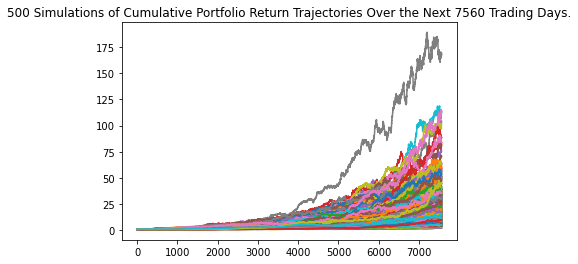

In [19]:
# Plot simulation outcomes
stock_line_plot = MC_Stock.plot_simulation()

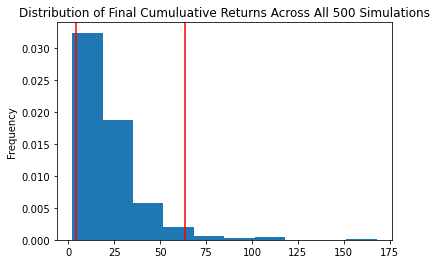

In [20]:
# Plot probability distribution and confidence intervals
stock_dist_plot = MC_Stock.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_tbl = MC_Stock.summarize_cumulative_return()

# Print summary statistics
print(stock_tbl)

count           500.000000
mean             22.127866
std              17.694051
min               2.136968
25%              10.671980
50%              17.388296
75%              27.829181
max             167.805205
95% CI Lower      4.212398
95% CI Upper     63.483324
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(stock_tbl[8] * initial_investment, 2)
ci_upper = round(stock_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $84247.96 and $1269666.48


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(stock_tbl[8] * initial_investment, 2)
ci_upper = round(stock_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $126371.94 and $1904499.72


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_Stock_5yr = MCSimulation(
    portfolio_data= df_stock_data,
    weights = [.40, .60],
    num_simulation= 500,
    num_trading_days=252 * 5
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_Stock_5yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Desktop\NWBootcamp\Homework\Homework-API\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999075,0.992300,0.996094,0.987022,0.996884,0.997696,0.991939,0.993126,1.005123,1.011030,...,1.002793,0.998612,1.006692,1.006490,1.005101,1.007779,0.999416,0.997399,0.998440,1.005438
2,1.004490,0.989783,1.003914,0.992394,0.993334,1.007228,0.997023,0.986029,1.007903,1.023982,...,1.003891,0.994524,1.015726,1.020146,1.003851,1.004289,0.990671,0.990777,0.992215,1.006012
3,0.999392,0.995475,1.008197,0.994095,0.986067,0.999524,1.013857,0.979339,1.018587,1.024886,...,0.994771,0.973869,1.021836,1.044447,0.997235,1.004165,1.001314,0.983574,0.990281,1.009828
4,1.013062,0.999885,0.994108,0.988811,0.985724,1.002239,1.009342,0.977637,1.007843,1.022366,...,0.998852,0.974550,1.018499,1.037092,0.994680,1.018386,1.013760,0.983981,0.980049,1.003686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.137265,1.348962,2.921119,3.028346,1.139814,1.501943,2.289838,1.158772,1.318471,1.374928,...,2.294049,2.000078,1.232983,2.800654,1.790301,1.921254,1.040533,1.307468,1.682647,1.493559
1257,2.140845,1.336568,2.924348,3.027874,1.143522,1.479435,2.270466,1.171697,1.310070,1.363490,...,2.308524,2.016596,1.236376,2.795954,1.801580,1.913386,1.041701,1.310601,1.652640,1.508375
1258,2.126114,1.357049,2.947418,2.984422,1.139971,1.449899,2.270843,1.171850,1.318939,1.337325,...,2.312752,1.983510,1.221583,2.778732,1.791684,1.912241,1.040054,1.294988,1.664158,1.502524
1259,2.116652,1.346796,2.943849,2.978970,1.145912,1.450378,2.251724,1.175493,1.327363,1.330575,...,2.339115,2.001256,1.242131,2.728695,1.801614,1.901085,1.026843,1.297405,1.687396,1.497591


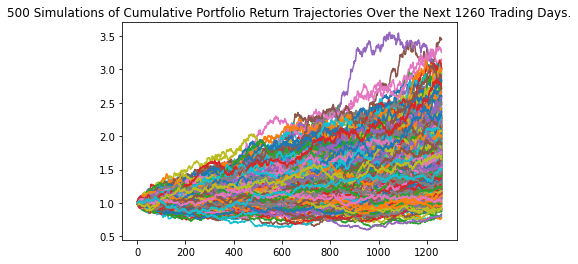

In [26]:
# Plot simulation outcomes
stock_5yr_line_plot = MC_Stock_5yr.plot_simulation()

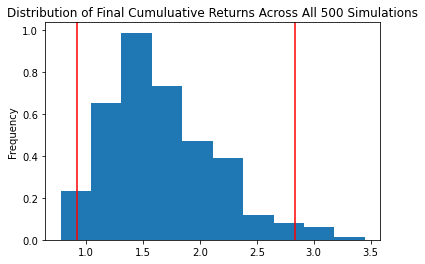

In [27]:
# Plot probability distribution and confidence intervals
stock_5yr_dist_plot = MC_Stock_5yr.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_5yr_tbl = MC_Stock_5yr.summarize_cumulative_return()

# Print summary statistics
print(stock_5yr_tbl)

count           500.000000
mean              1.665190
std               0.475010
min               0.774308
25%               1.319809
50%               1.576984
75%               1.963133
max               3.449264
95% CI Lower      0.920368
95% CI Upper      2.838230
Name: 1260, dtype: float64


In [29]:
# Set initial investment
new_initial_investment_5yr = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(stock_5yr_tbl[8] * new_initial_investment_5yr, 2)
ci_upper_five = round(stock_5yr_tbl[9] * new_initial_investment_5yr, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${new_initial_investment_5yr} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 5 years will end within in the range of $92036.84 and $283822.95


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_Stock_10yr = MCSimulation(
    portfolio_data= df_stock_data,
    weights = [.40, .60],
    num_simulation= 500,
    num_trading_days=252 * 10
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_Stock_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


D:\Desktop\NWBootcamp\Homework\Homework-API\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000227,1.006481,0.980571,1.005890,0.994638,1.005054,0.993610,1.008675,1.000451,1.012509,...,0.984774,1.010794,1.001238,0.987028,1.003339,0.980291,1.009230,0.988459,0.994643,0.989864
2,1.003055,1.015186,0.968881,1.004660,1.011818,0.984031,0.987897,0.998074,0.992333,1.008629,...,0.973726,1.018157,1.013225,0.990826,0.997852,0.992505,1.008389,0.980814,0.993710,0.984889
3,1.005050,1.008036,0.969227,1.010752,1.008697,0.996121,1.005942,0.999748,0.992626,1.016512,...,0.982359,1.036402,1.015144,0.985163,0.985696,0.992753,0.989551,0.962646,1.001584,0.988218
4,1.032647,1.005203,0.973731,1.021578,1.017351,0.993949,1.003062,0.995213,0.976988,1.025540,...,0.978998,1.052505,1.005618,0.986968,0.978488,0.987905,0.987291,0.966016,1.007941,0.979690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.260729,2.453493,1.219839,1.188199,2.027162,4.703335,1.805361,2.180598,2.626791,2.264260,...,1.596465,4.940871,1.745097,2.263963,0.902443,2.267622,2.707910,1.161506,1.664533,2.212908
2517,4.275806,2.475818,1.219191,1.193937,1.995417,4.621994,1.810717,2.205023,2.625851,2.263934,...,1.593743,4.897550,1.757325,2.290305,0.892496,2.273098,2.731730,1.157184,1.653452,2.224153
2518,4.331836,2.458039,1.240118,1.183982,1.973318,4.600093,1.820837,2.200629,2.614995,2.279577,...,1.595330,4.866218,1.780910,2.308656,0.893207,2.282820,2.753525,1.150436,1.654356,2.258827
2519,4.382684,2.497660,1.227722,1.176728,1.972248,4.582857,1.807705,2.206113,2.617365,2.247113,...,1.611286,4.959527,1.795029,2.322076,0.897987,2.263726,2.756565,1.156651,1.658325,2.290468


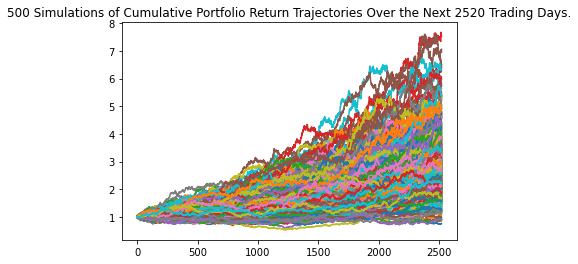

In [32]:
# Plot simulation outcome
stock_10yr_line_plot = MC_Stock_10yr.plot_simulation()

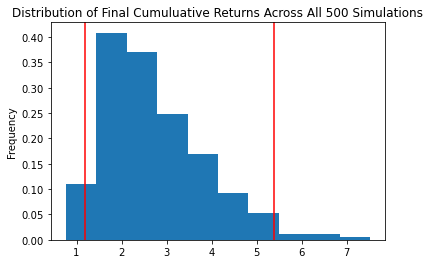

In [33]:
# Plot probability distribution and confidence intervals
stock_10yr_dist_plot = MC_Stock_10yr.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_10yr_tbl = MC_Stock_10yr.summarize_cumulative_return()

# Print summary statistics
print(stock_10yr_tbl)

count           500.000000
mean              2.732757
std               1.134123
min               0.761642
25%               1.922114
50%               2.477939
75%               3.412578
max               7.520483
95% CI Lower      1.192761
95% CI Upper      5.380240
Name: 2520, dtype: float64


In [35]:
# Set initial investment
new_initial_investment_10yr = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(stock_10yr_tbl[8] * new_initial_investment_10yr, 2)
ci_upper_ten = round(stock_10yr_tbl[9] * new_initial_investment_10yr, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${new_initial_investment_10yr} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $119276.13 and $538023.95
